### Imports

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pickle
from models import NonLinearModel, NonLinearController, ClosedLoopSystem
from contractive_REN import ContractiveREN
from utils import set_params
from dataset import SystemIdentificationDataset
from torch.utils.data import DataLoader, random_split

### Simulation parameters

In [22]:
# Define simulation parameters
x0, input_dim, state_dim, output_dim, input_noise_std, output_noise_std, horizon, num_signals, batch_size, ts, learning_rate, epochs, n_xi, l = set_params()

### Plant, controller and closed loop

In [23]:
#-------------------------1. Create the plant and controller------------------------------------
plant = NonLinearModel(state_dim=state_dim, input_dim=input_dim, output_dim=output_dim)
controller = NonLinearController(input_k_dim=output_dim, output_k_dim=input_dim)
closed_loop = ClosedLoopSystem(plant, controller)

## Closed-loop data generation

In [24]:
#-------------------------2. Generate closed loop data---------------------------------------------
dataset = SystemIdentificationDataset(num_signals = num_signals, horizon = horizon, input_dim = input_dim, state_dim = state_dim, output_dim = output_dim, closed_loop = closed_loop, input_noise_std = input_noise_std, output_noise_std = output_noise_std, fixed_x0 = x0)

# Compute split sizes
train_size = 30
val_size = 6
test_size = 4

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#training data
train_indices = train_dataset.indices  # Get training sample indices
# Extract only the training subset of the dataset
external_input_data_train = train_dataset.dataset.external_input_data[train_indices]
plant_input_data_train = train_dataset.dataset.plant_input_data[train_indices]
output_data_train = train_dataset.dataset.output_data[train_indices]

### Plots: closed loop trajectories of the real system: training data

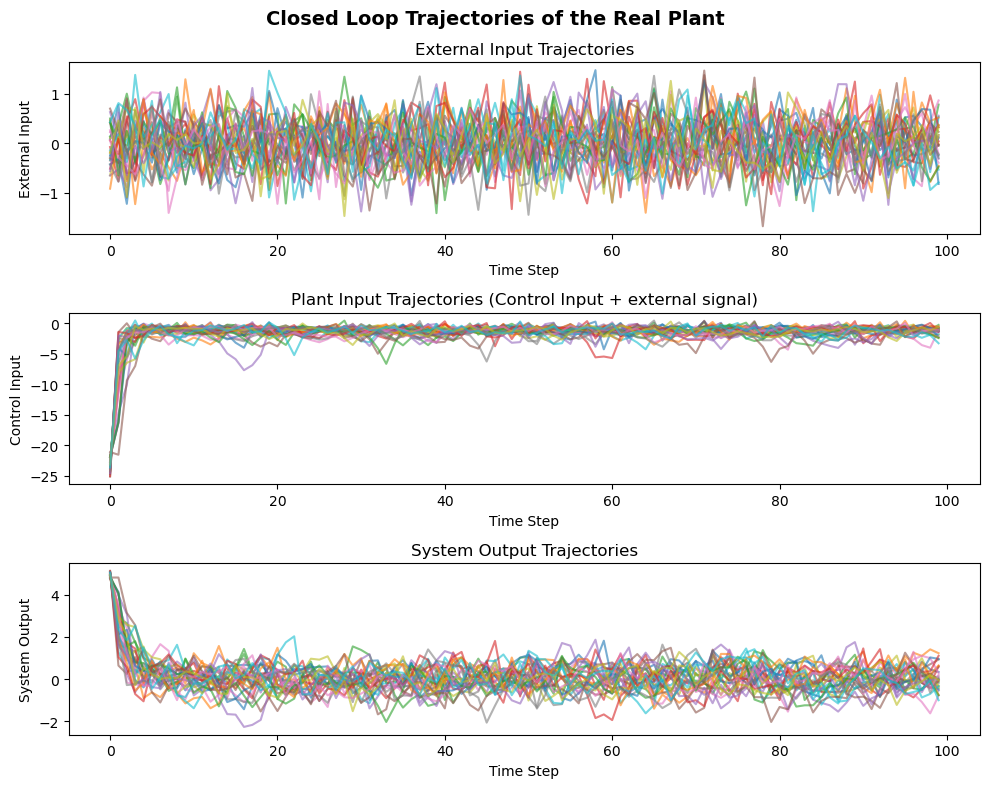

In [25]:
#-------------------------plot closed loop training data---------------------------------------------------

# Convert tensors to numpy for plotting
external_input_np = external_input_data_train.detach().numpy()
plant_input_np = plant_input_data_train.detach().numpy()
output_np = output_data_train.detach().numpy()

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8))

# Plot External Inputs
axes[0].plot(external_input_np[:, :, 0].T, alpha=0.6)
axes[0].set_title("External Input Trajectories")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("External Input")

# Plot Plant Inputs (Controller Outputs)
axes[1].plot(plant_input_np[:, :, 0].T, alpha=0.6)
axes[1].set_title("Plant Input Trajectories (Control Input + external signal)")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Control Input")

# Plot System Outputs
axes[2].plot(output_np[:, :, 0].T, alpha=0.6)
axes[2].set_title("System Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Closed Loop Trajectories of the Real Plant", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# System identification of G

### REN model, loss function and optimizer


In [26]:
#--------------------------3. Define model for sysid---------------------------------------------
#create the REN model for G
y_init = x0
REN_G = ContractiveREN(input_dim= input_dim, output_dim= output_dim, state_dim=n_xi, dim_nl= l)
#create the closed loop with the identified model
closed_loop_G = ClosedLoopSystem(REN_G, controller)

#--------------------------4. Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam(REN_G.parameters(), lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [27]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_G.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_G.train()
    loss_epoch = 0.0  # Accumulate training loss

    for _, u_batch, y_batch in train_loader:
        u_batch, y_batch = u_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_hat_train_G = REN_G(x0, u_batch)
        loss_batch = MSE(y_hat_train_G, y_batch)


        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_G.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for _, u_batch, y_batch in val_loader:
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)

            y_hat_val = REN_G(x0, u_batch)
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
torch.save(REN_G.state_dict(), 'REN_G_trained_model.pth')

Epoch: 1 	||	 Training Loss: 1.546270 	||	 Validation Loss: 1.106798
Epoch: 2 	||	 Training Loss: 1.033901 	||	 Validation Loss: 0.778475
Epoch: 3 	||	 Training Loss: 0.707819 	||	 Validation Loss: 0.525805
Epoch: 4 	||	 Training Loss: 0.500834 	||	 Validation Loss: 0.393532
Epoch: 5 	||	 Training Loss: 0.392851 	||	 Validation Loss: 0.325572


KeyboardInterrupt: 

### Plots: identification results for G

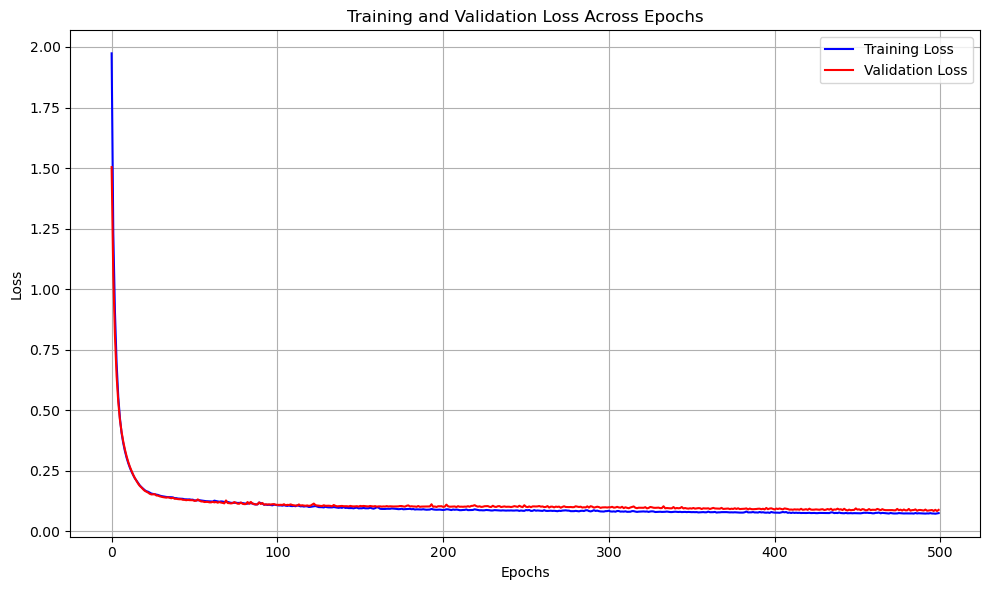

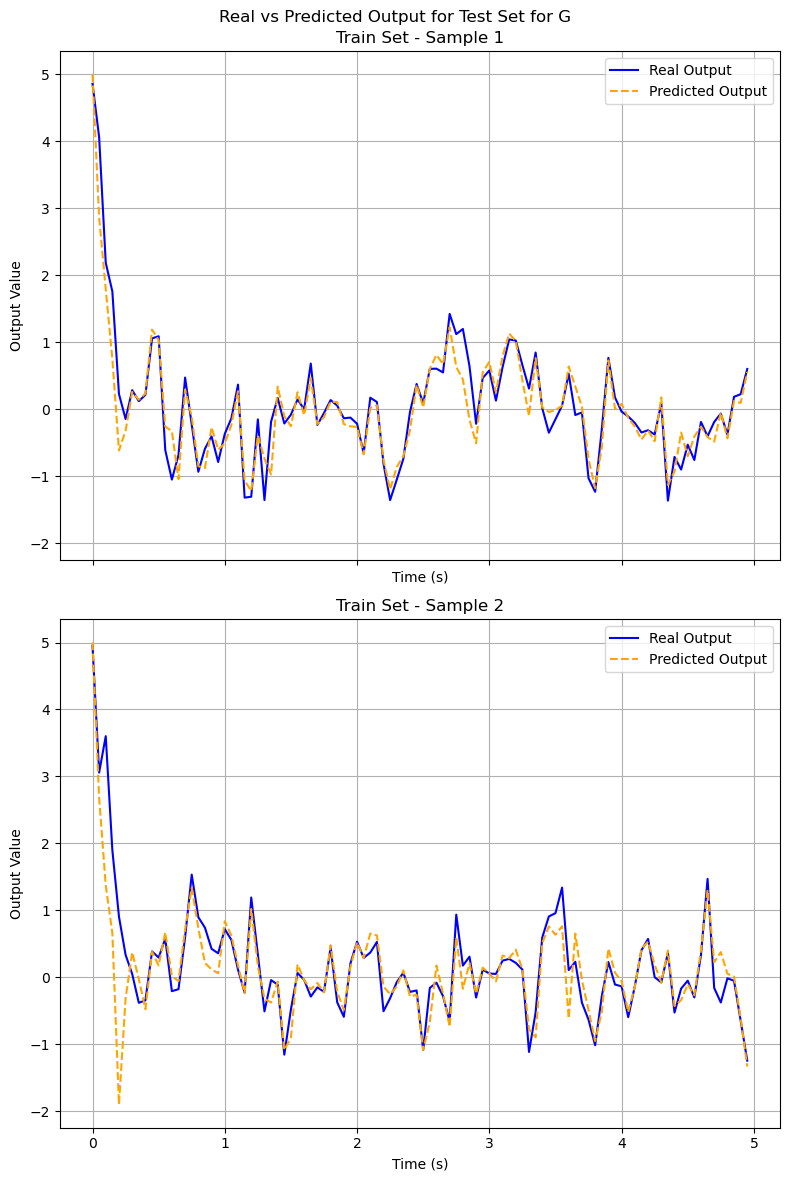

In [8]:
# --------------Plot identification results for G-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=len(test_loader), ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i, (_, u_batch, y_batch) in enumerate(test_loader):
    u_batch, y_batch = u_batch.to(device), y_batch.to(device)
    # Plot comparison between real and predicted for training set
    REN_G.eval()
    y_hat = REN_G(x0, u_batch)
    
    y_batch_np = y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()
    
    # Time array for plotting
    time_plot = np.arange(0, u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Train Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Test Set for G")
plt.tight_layout()
plt.show()


### Plots: open loop simulation of the identified model G

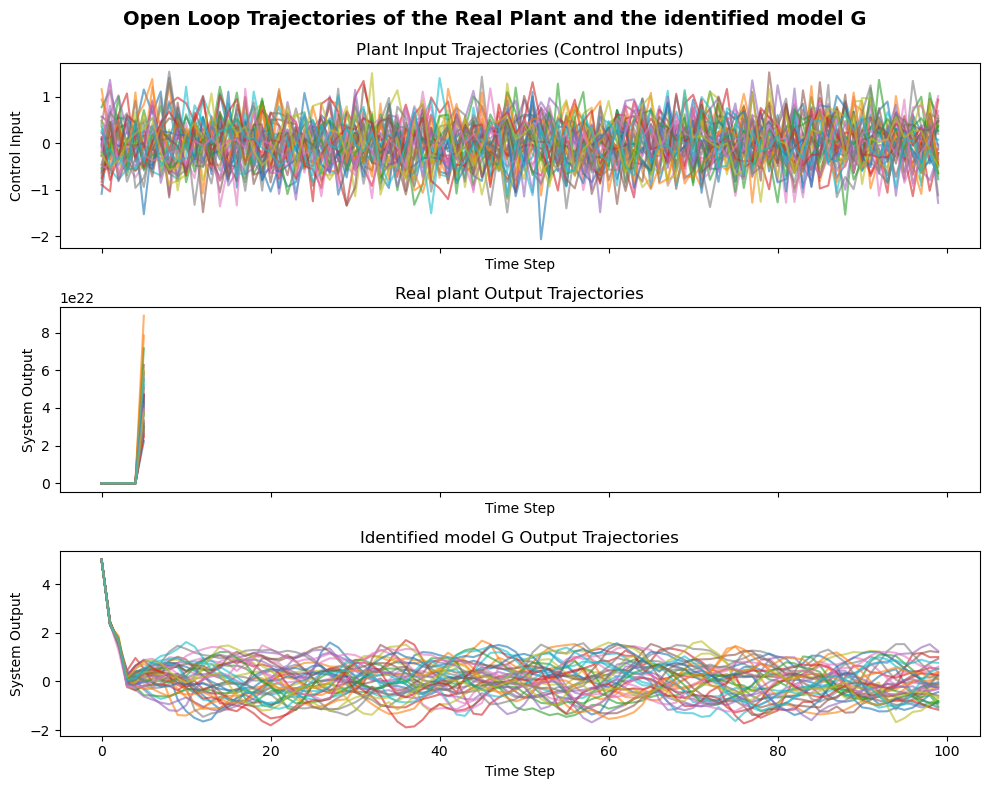

In [9]:
#-------------------------plot open loop simulation of the real plant and the identified model G----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = plant(x0 = x0, u_ext = u_OL, output_noise_std = output_noise_std)

REN_G.eval()
y_OL_G = REN_G(x0, u_OL)

# Convert tensors to numpy for plotting
u_OL = u_OL.detach().numpy()
y_OL = y_OL.detach().numpy()
y_OL_G = y_OL_G.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
axes[0].plot(u_OL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Plant Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Control Input")

# Plot Plant Outputs
axes[1].plot(y_OL[:, :, 0].T, alpha=0.6)
axes[1].set_title("Real plant Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
axes[2].plot(y_OL_G[:, :, 0].T, alpha=0.6)
axes[2].set_title("Identified model G Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified model G", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Deployment: closed loop simulation of the identified model G

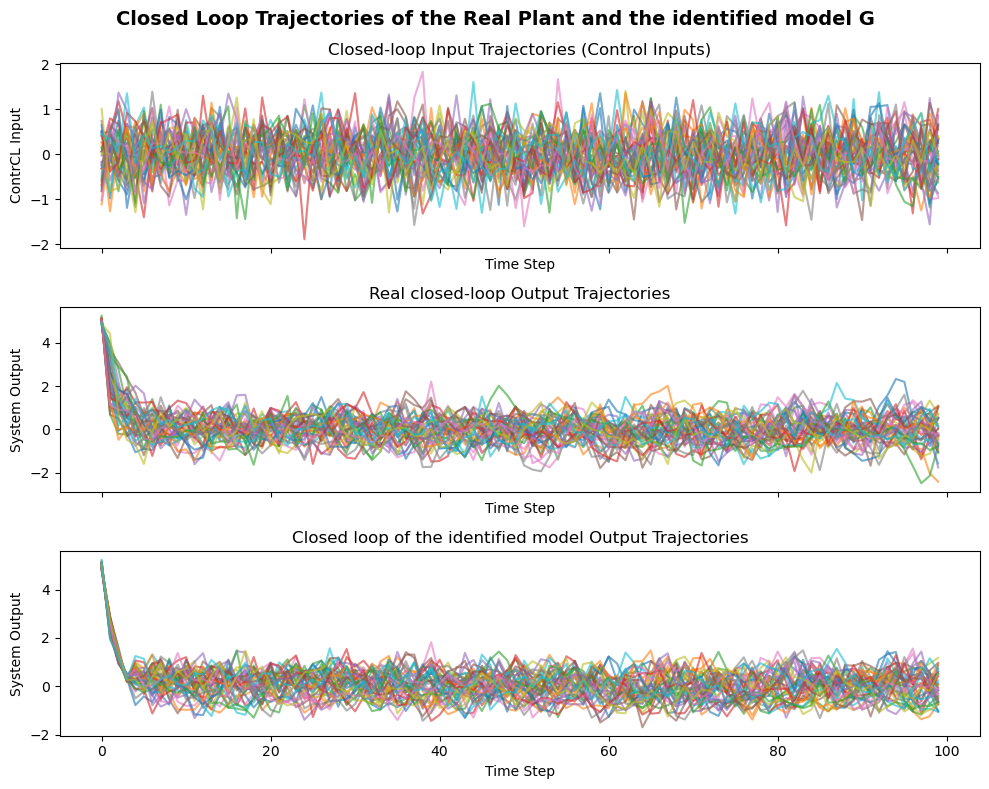

In [10]:
#-------------------------plot closed loop simulation of the real plant and the identified model G----------------------------------------------------

u_CL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
_, y_CL = closed_loop(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)
closed_loop_G.eval()
_, y_CL_G = closed_loop_G(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

# Convert tensors to numpy for plotting
u_CL = u_CL.detach().numpy()
y_CL = y_CL.detach().numpy()
y_CL_G = y_CL_G.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
axes[0].plot(u_CL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Closed-loop Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("ContrCL Input")

# Plot Plant Outputs
axes[1].plot(y_CL[:, :, 0].T, alpha=0.6)
axes[1].set_title("Real closed-loop Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
axes[2].plot(y_CL_G[:, :, 0].T, alpha=0.6)
axes[2].set_title("Closed loop of the identified model Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Closed Loop Trajectories of the Real Plant and the identified model G", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Plots: residual analysis


In [11]:
# # Residual Analysis: Plot residuals and their distribution
# residuals = y_OL - y_OL_G
# 
# # Create a figure with three subplots
# fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
# 
# # Plot residuals
# axes[0].plot(residuals[:, :, 0].T, alpha=0.6)
# axes[0].set_title("Residuals")
# axes[0].set_xlabel("Time Step")
# axes[0].set_ylabel("Residual")
# 
# #plot histograms
# finite_residuals = residuals[0, :, :][np.isfinite(residuals[0, :, :])]
# axes[1].hist(finite_residuals, bins=30, edgecolor='k')
# axes[1].set_title("Histogram of Residuals")
# axes[1].set_xlabel("Residuals")
# axes[1].set_ylabel("Frequency")
# 
# 
# 
# fig.suptitle("Residuals for the open loop simulation of the identified model G", fontsize=14, fontweight="bold")
# plt.tight_layout()
# plt.show()


# System identification of the negative feedback of K and S 

### Closed loop model of REN in negative feedback with K, loss function and optimizer

In [12]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S
y_init = x0
REN_S = ContractiveREN(input_dim = input_dim, output_dim = output_dim, state_dim = n_xi, dim_nl = l)
closed_loop_REN = ClosedLoopSystem(REN_S, controller, negative=True)

#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()

optimizer = torch.optim.Adam(REN_S.parameters(), lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [13]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_S.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs

for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    closed_loop_REN.train()
    loss_epoch = 0.0  # Accumulate training loss

    for _, u_batch, y_batch in train_loader:
        u_batch, y_batch = u_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        _, y_hat_train_S = closed_loop_REN(x0, u_batch, output_noise_std=0)

        if torch.isnan(y_hat_train_S).any() or torch.isinf(y_hat_train_S).any():
            y_hat_train_S = torch.nan_to_num(y_hat_train_S, nan=1e5, posinf=1e5, neginf=-1e5)
            for name, param in closed_loop_REN.named_parameters():
                print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

        loss_batch = MSE(y_hat_train_S, y_batch)

        loss_batch.backward()

        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    closed_loop_REN.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for _, u_batch, y_batch in val_loader:
            u_batch, y_batch = u_batch.to(device), y_batch.to(device)

            _, y_hat_val = closed_loop_REN(x0, u_batch, output_noise_std=0)

            if torch.isnan(y_hat_val).any() or torch.isinf(y_hat_val).any():
                y_hat_val = torch.nan_to_num(y_hat_val, nan=1e5, posinf=1e5, neginf=-1e5)
                for name, param in closed_loop_REN.named_parameters():
                    print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")

            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
torch.save(REN_S.state_dict(), 'REN_S_trained_model.pth')

system_model.X: mean -0.010163437575101852, std 0.49304354190826416
system_model.Y: mean 0.027280401438474655, std 0.6187766790390015
system_model.B2: mean 0.06101992726325989, std 0.5929622054100037
system_model.C2: mean 0.30316048860549927, std 0.7312874794006348
system_model.D21: mean -0.018626250326633453, std 0.5067666172981262
system_model.D22: mean 0.40513885021209717, std nan
system_model.D12: mean 0.08375449478626251, std 0.3173174262046814
system_model.X: mean nan, std nan
system_model.Y: mean nan, std nan
system_model.B2: mean nan, std nan
system_model.C2: mean nan, std nan
system_model.D21: mean nan, std nan
system_model.D22: mean nan, std nan
system_model.D12: mean nan, std nan


/var/folders/8z/6_3zvgk14d5cj9bvfskmt5qh0000gn/T/ipykernel_33295/974438417.py:22: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_581jc0ddx6/croot/pytorch-select_1730848714937/work/aten/src/ATen/native/ReduceOps.cpp:1807.)
  print(f"{name}: mean {param.data.mean()}, std {param.data.std()}")


_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix contained non-finite values.

### Plots: identification results for the negative feedback of S and K

In [ ]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model's Predictions vs Actual Output for the training set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from training data
    _, sample_u_batch, sample_y_batch = next(iter(train_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for training set
    closed_loop_REN.eval()

    _, y_hat = closed_loop_REN(x0, sample_u_batch, output_noise_std=0)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Train Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Training Set for S")
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from test data
    _, sample_u_batch, sample_y_batch = next(iter(test_loader))  # Get a sample batch
    sample_u_batch, sample_y_batch = sample_u_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for test set
    closed_loop_REN.eval()

    _, y_hat = closed_loop_REN(x0, sample_u_batch, output_noise_std=0)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Test Set - Sample {i+1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Test Set for S")
plt.tight_layout()
plt.show()

### Plots: open loop simulation of the identified model of S in feedback with K

In [ ]:
#-------------------------plot open loop simulation of the real plant and the identified model S in closed loop with K----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = plant(x0 = x0, u_ext = u_OL, output_noise_std = output_noise_std)

closed_loop_REN.eval()
_, y_OL_S = closed_loop_REN(x0, u_OL, output_noise_std=0)

# Convert tensors to numpy for plotting
u_OL = u_OL.detach().numpy()
y_OL = y_OL.detach().numpy()
y_OL_S = y_OL_S.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
axes[0].plot(u_OL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Plant Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Control Input")

# Plot Plant Outputs
axes[1].plot(y_OL[:, :, 0].T, alpha=0.6)
axes[1].set_title("Real plant Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
axes[2].plot(y_OL_S[:, :, 0].T, alpha=0.6)
axes[2].set_title("Identified model S Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified model S", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Deployment: closed loop simulation of the identified model of S in feedback with K

### Plots: residual analysis

In [ ]:
# # Residual Analysis: Plot residuals and their distribution
# residuals = y_OL - y_OL_G
# 
# # Create a figure with three subplots
# fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
# 
# # Plot residuals
# axes[0].plot(residuals[:, :, 0].T, alpha=0.6)
# axes[0].set_title("Residuals")
# axes[0].set_xlabel("Time Step")
# axes[0].set_ylabel("Residual")
# 
# #plot histograms
# finite_residuals = residuals[0, :, :][np.isfinite(residuals[0, :, :])]
# axes[1].hist(finite_residuals, bins=30, edgecolor='k')
# axes[1].set_title("Histogram of Residuals")
# axes[1].set_xlabel("Residuals")
# axes[1].set_ylabel("Frequency")
# 
# 
# 
# fig.suptitle("Residuals for the open loop simulation of the identified model G", fontsize=14, fontweight="bold")
# plt.tight_layout()
# plt.show()

## System identification of S using reference inputs

In [14]:
#-----------------------------closedloop sysid of S through RENs------------------------
#--------------------------Define model for sysid---------------------------------------------
#create the REN model for S

y_init = x0
REN_S_2 = ContractiveREN(input_dim=input_dim, output_dim=output_dim, state_dim=n_xi, dim_nl=l)
closed_loop_REN_2 = ClosedLoopSystem(REN_S_2, controller, negative=True)
#create the closed loop with the identified model which is itself a closed loop
closed_loop_closed_loop_2 = ClosedLoopSystem(closed_loop_REN_2, controller)

#--------------------------Define the loss function and optimizer---------------------------------------------
MSE = nn.MSELoss()
optimizer = torch.optim.Adam(REN_S_2.parameters(), lr=learning_rate)
optimizer.zero_grad()

### Training and validation loop

In [15]:
#--------------------------5. Training---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
REN_S_2.to(device)
train_losses = []
val_losses = []  # Store validation losses across epochs
for epoch in range(epochs):
    # ---------------- TRAINING ---------------- #
    REN_S_2.train()
    loss_epoch = 0.0  # Accumulate training loss

    for u_ext_batch, _, y_batch in train_loader:
        u_ext_batch, y_batch = u_ext_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_hat_train_G = REN_S_2(x0, u_ext_batch)
        loss_batch = MSE(y_hat_train_G, y_batch)


        loss_batch.backward()
        optimizer.step()

        loss_epoch += loss_batch.item()

    loss_epoch /= len(train_loader)
    train_losses.append(loss_epoch)

    # ---------------- VALIDATION ---------------- #
    REN_S_2.eval()
    loss_val_epoch = 0.0

    with torch.no_grad():
        for u_ext_batch, _, y_batch in val_loader:
            u_ext_batch, y_batch = u_ext_batch.to(device), y_batch.to(device)
            
            y_hat_val = REN_S_2(x0, u_ext_batch)
            loss_batch_val = MSE(y_hat_val, y_batch)

            loss_val_epoch += loss_batch_val.item()

    loss_val_epoch /= len(val_loader)
    val_losses.append(loss_val_epoch)  # Store validation loss for plotting

    print(f"Epoch: {epoch + 1} \t||\t Training Loss: {loss_epoch:.6f} \t||\t Validation Loss: {loss_val_epoch:.6f}")

# Save the trained model
torch.save(REN_S_2.state_dict(), 'REN_G_trained_model.pth')

Epoch: 1 	||	 Training Loss: 0.085116 	||	 Validation Loss: 0.053364
Epoch: 2 	||	 Training Loss: 0.054031 	||	 Validation Loss: 0.045576
Epoch: 3 	||	 Training Loss: 0.051005 	||	 Validation Loss: 0.044261
Epoch: 4 	||	 Training Loss: 0.050173 	||	 Validation Loss: 0.044644
Epoch: 5 	||	 Training Loss: 0.050034 	||	 Validation Loss: 0.044159
Epoch: 6 	||	 Training Loss: 0.049586 	||	 Validation Loss: 0.044132
Epoch: 7 	||	 Training Loss: 0.049645 	||	 Validation Loss: 0.043722
Epoch: 8 	||	 Training Loss: 0.049426 	||	 Validation Loss: 0.044449
Epoch: 9 	||	 Training Loss: 0.049522 	||	 Validation Loss: 0.044573
Epoch: 10 	||	 Training Loss: 0.049521 	||	 Validation Loss: 0.043682
Epoch: 11 	||	 Training Loss: 0.049545 	||	 Validation Loss: 0.044299
Epoch: 12 	||	 Training Loss: 0.049443 	||	 Validation Loss: 0.043838
Epoch: 13 	||	 Training Loss: 0.049973 	||	 Validation Loss: 0.044435
Epoch: 14 	||	 Training Loss: 0.050054 	||	 Validation Loss: 0.043609
Epoch: 15 	||	 Training Loss:

### Plots: identification results

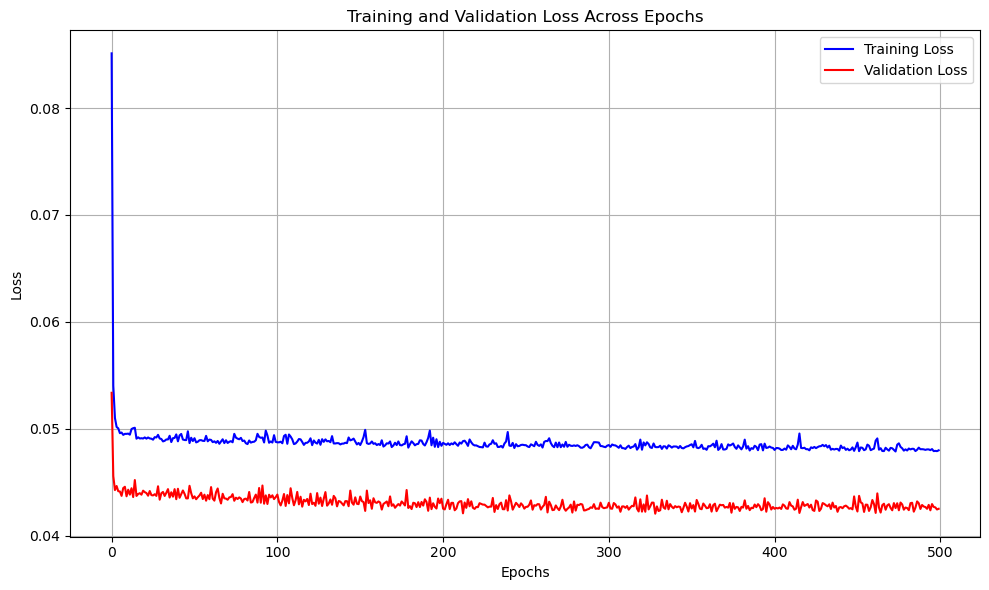

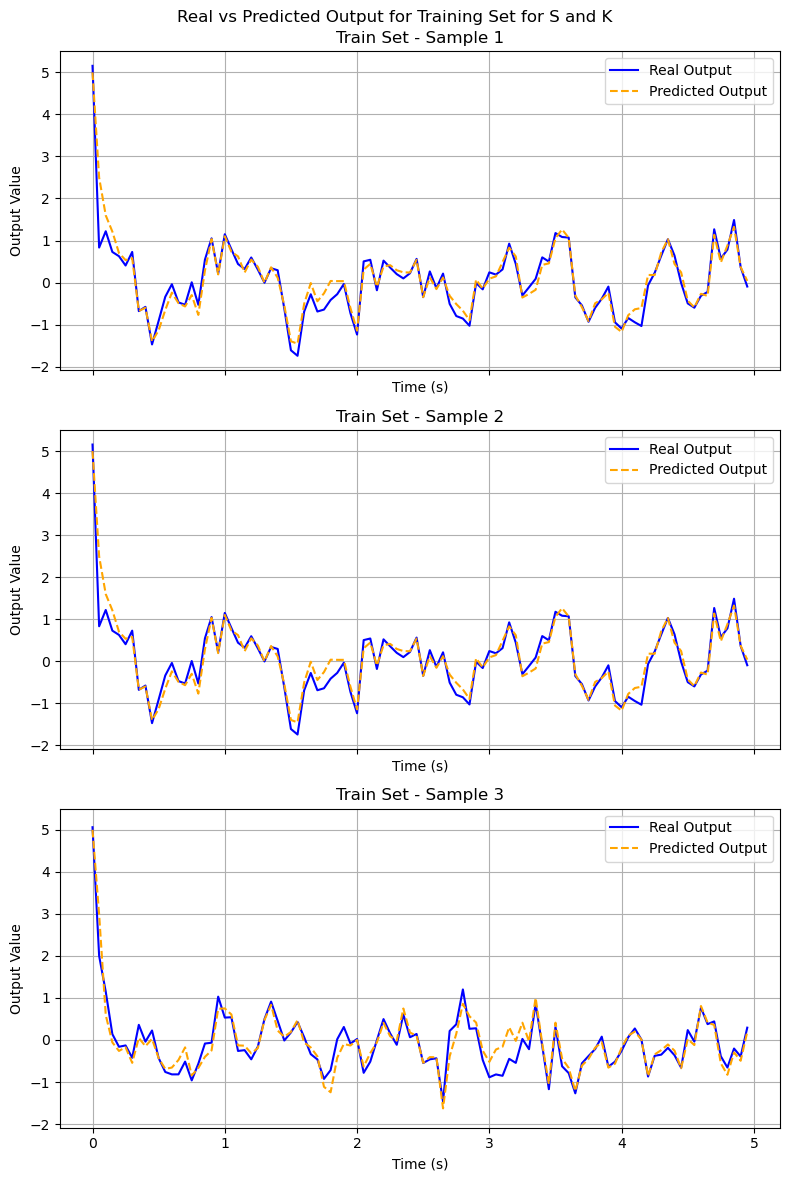

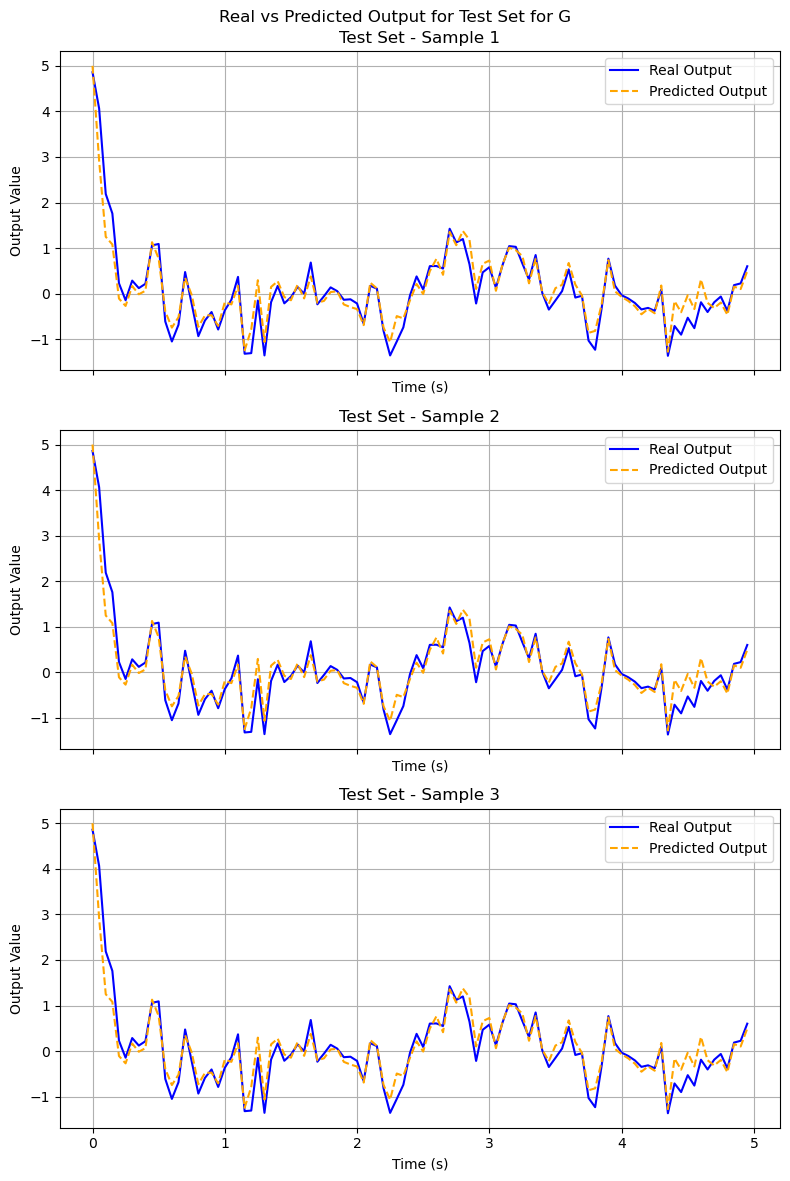

In [16]:
# --------------Plot identification results for S-----------------

#Training and Validation Loss Across Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Validation Loss', color='red')  # Assuming val_losses are collected
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the training set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from training data
    sample_u_ext_batch, _, sample_y_batch = next(iter(train_loader))  # Get a sample batch
    sample_u_ext_batch, sample_y_batch = sample_u_ext_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for training set
    REN_S_2.eval()

    y_hat = REN_S_2(x0, sample_u_ext_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_ext_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Train Set - Sample {i + 1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Training Set for S and K")
plt.tight_layout()
plt.show()

# Model's Predictions vs Actual Output for the test set
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(3):  # Choose 3 batches from test data
    sample_u_ext_batch, _, sample_y_batch = next(iter(test_loader))  # Get a sample batch
    sample_u_ext_batch, sample_y_batch = sample_u_ext_batch.to(device), sample_y_batch.to(device)

    # Plot comparison between real and predicted for test set
    REN_S_2.eval()

    y_hat = REN_S_2(x0, sample_u_ext_batch)

    # Convert to numpy for plotting
    y_batch_np = sample_y_batch.detach().cpu().numpy()
    y_hat_np = y_hat.detach().cpu().numpy()

    # Time array for plotting
    time_plot = np.arange(0, sample_u_ext_batch.shape[1] * ts, ts)

    # Plot comparison for each signal
    axes[i].plot(time_plot, y_batch_np[0, :, 0], label="Real Output", color="blue")
    axes[i].plot(time_plot, y_hat_np[0, :, 0], label="Predicted Output", linestyle="--", color="orange")
    axes[i].set_title(f"Test Set - Sample {i + 1}")
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Output Value")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Real vs Predicted Output for Test Set for G")
plt.tight_layout()
plt.show()

### Plots: open loop simulation of the identified model of S in feedback with K


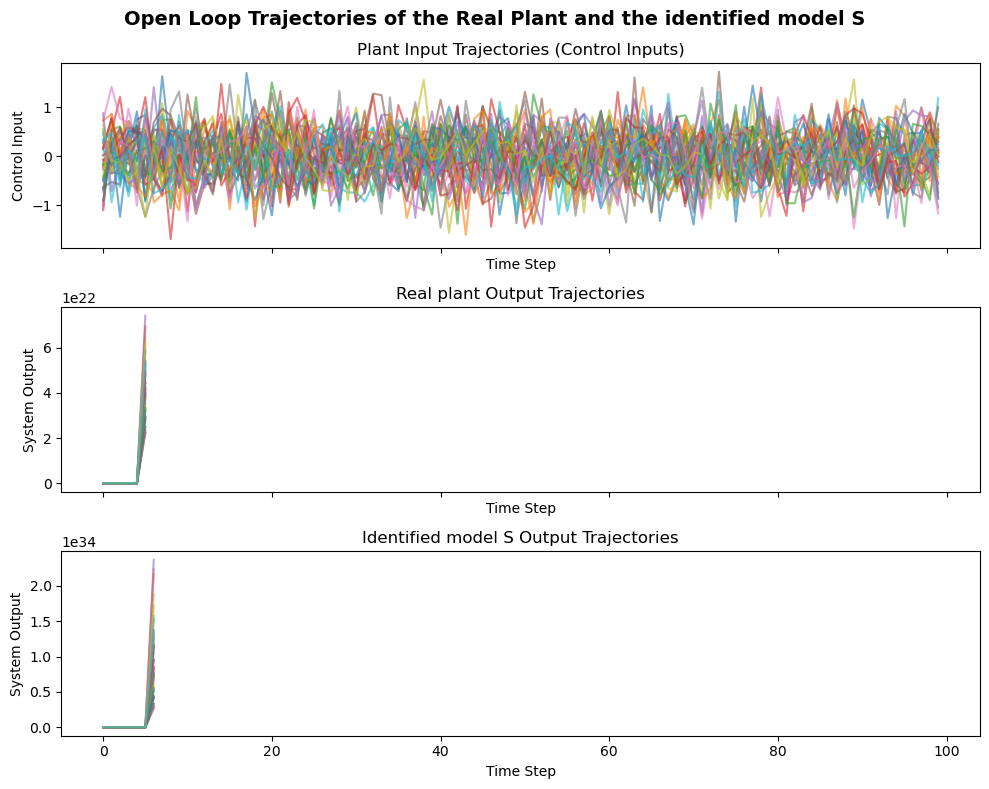

In [17]:
#-------------------------plot open loop simulation of the real plant and the identified model S in closed loop with K----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = plant(x0 = x0, u_ext = u_OL, output_noise_std = output_noise_std)

closed_loop_REN_2.eval()
_, y_OL_S = closed_loop_REN_2(x0, u_OL, output_noise_std=0)

# Convert tensors to numpy for plotting
u_OL = u_OL.detach().numpy()
y_OL = y_OL.detach().numpy()
y_OL_S = y_OL_S.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
axes[0].plot(u_OL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Plant Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Control Input")

# Plot Plant Outputs
axes[1].plot(y_OL[:, :, 0].T, alpha=0.6)
axes[1].set_title("Real plant Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
axes[2].plot(y_OL_S[:, :, 0].T, alpha=0.6)
axes[2].set_title("Identified model S Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified model S", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Deployment: closed loop simulation of the identified model G

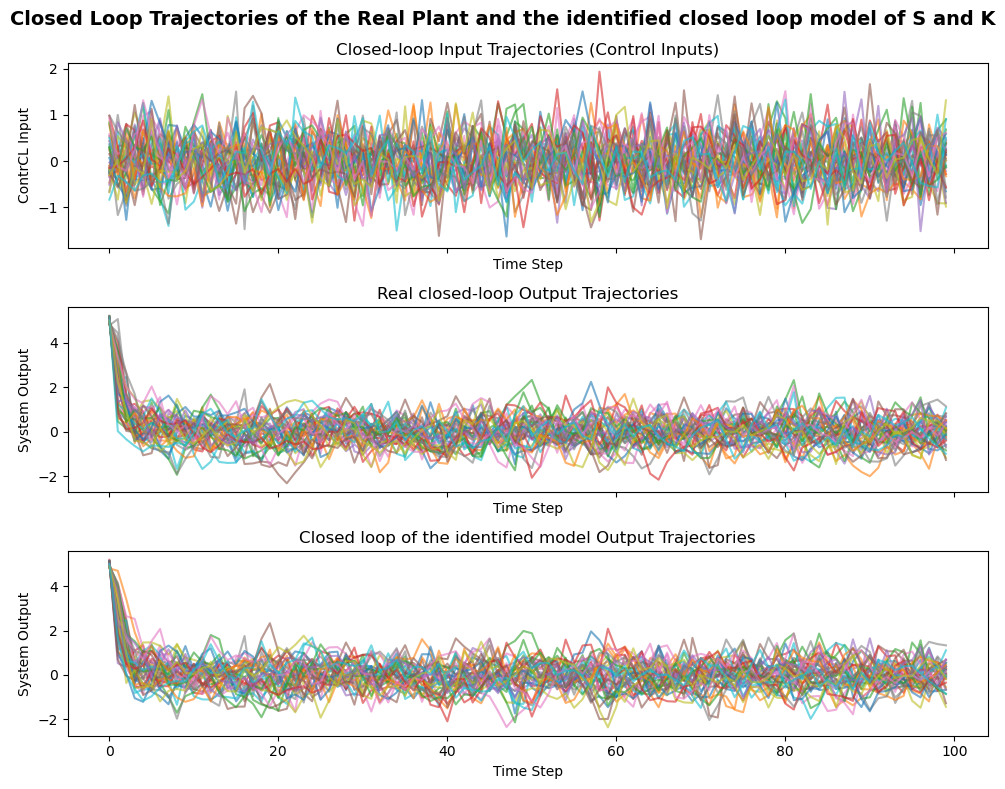

In [18]:
#-------------------------plot closed loop simulation of the real plant and the identified model G----------------------------------------------------

u_CL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
_, y_CL = closed_loop(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

closed_loop_closed_loop_2.eval()
_, y_CL_G = closed_loop_closed_loop_2(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

# Convert tensors to numpy for plotting
u_CL = u_CL.detach().numpy()
y_CL = y_CL.detach().numpy()
y_CL_G = y_CL_G.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Inputs
axes[0].plot(u_CL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Closed-loop Input Trajectories (Control Inputs)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("ContrCL Input")

# Plot Plant Outputs
axes[1].plot(y_CL[:, :, 0].T, alpha=0.6)
axes[1].set_title("Real closed-loop Output Trajectories")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")

# Plot Plant Outputs
axes[2].plot(y_CL_G[:, :, 0].T, alpha=0.6)
axes[2].set_title("Closed loop of the identified model Output Trajectories")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")

fig.suptitle("Closed Loop Trajectories of the Real Plant and the identified closed loop model of S and K", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Comparison between approaches

### Plots: comparison of the open loop simulations of the real an identified models with and without K

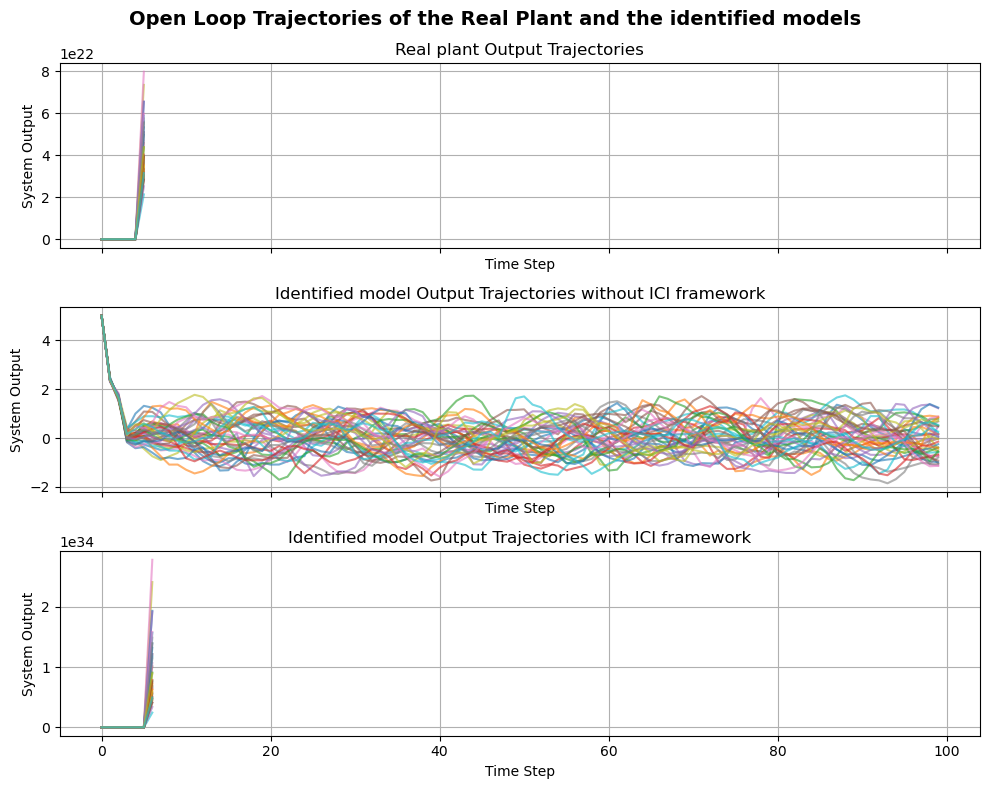

In [19]:
#-------------------------plot open loop simulation of the real plant and the identified model S in closed loop with K----------------------------------------------------
u_OL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
y_OL = plant(x0 = x0, u_ext = u_OL, output_noise_std = output_noise_std)

closed_loop_REN_2.eval()
_, y_OL_S = closed_loop_REN_2(x0, u_OL, output_noise_std=0)

REN_G.eval()
y_OL_G = REN_G(x0, u_OL)

# Convert tensors to numpy for plotting
y_OL = y_OL.detach().numpy()
y_OL_G = y_OL_G.detach().numpy()
y_OL_S = y_OL_S.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Plot Plant Outputs
axes[0].plot(y_OL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Real plant Output Trajectories")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("System Output")
axes[0].grid(True)

# Plot Plant Outputs
axes[1].plot(y_OL_G[:, :, 0].T, alpha=0.6)
axes[1].set_title("Identified model Output Trajectories without ICI framework")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")
axes[1].grid(True)

# Plot Plant Outputs
axes[2].plot(y_OL_S[:, :, 0].T, alpha=0.6)
axes[2].set_title("Identified model Output Trajectories with ICI framework")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")
axes[2].grid(True)

fig.suptitle("Open Loop Trajectories of the Real Plant and the identified models", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Plots: comparison of the closed loop simulations of the real an identified models with and without K

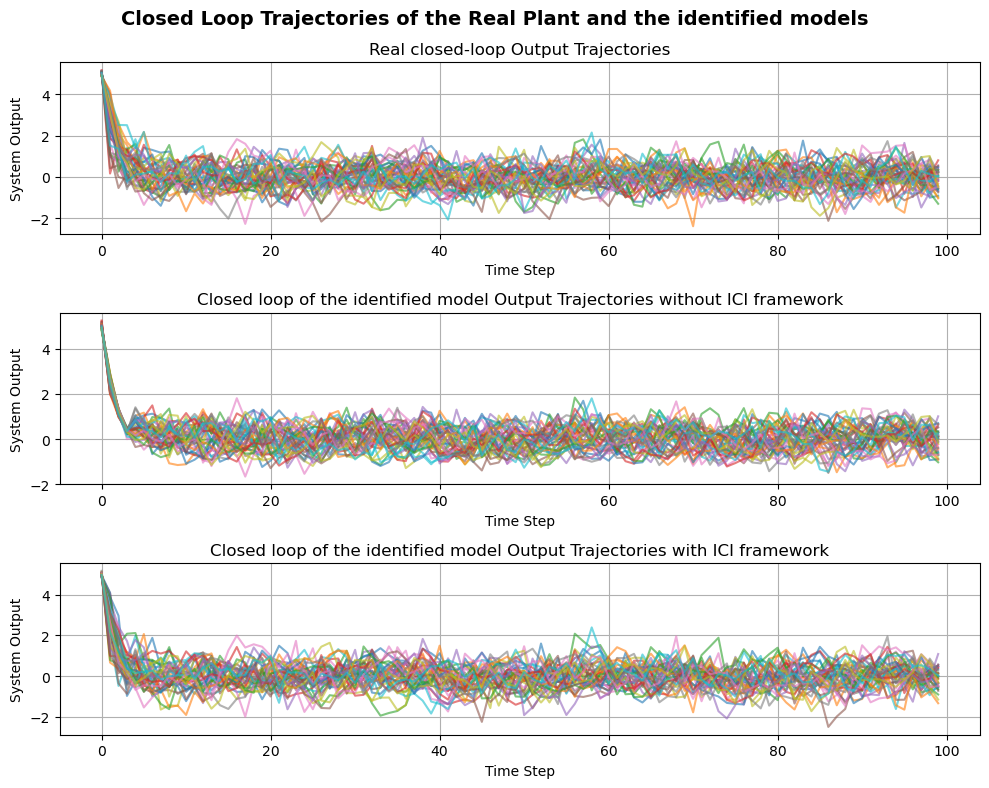

In [20]:
#-------------------------plot closed loop simulation of the real plant and the identified model G----------------------------------------------------
u_CL = torch.randn((num_signals, horizon, input_dim)) * input_noise_std
_, y_CL = closed_loop(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

closed_loop_G.eval()
_, y_CL_G = closed_loop_G(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

closed_loop_closed_loop_2.eval()
_, y_CL_G_2 = closed_loop_closed_loop_2(x0=x0, u_ext=u_CL, output_noise_std = output_noise_std)

# Convert tensors to numpy for plotting
y_CL_G_2 = y_CL_G_2.detach().numpy()
y_CL = y_CL.detach().numpy()
y_CL_G = y_CL_G.detach().numpy()

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)

# Plot Plant Inputs
axes[0].plot(y_CL[:, :, 0].T, alpha=0.6)
axes[0].set_title("Real closed-loop Output Trajectories")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("System Output")
axes[0].grid(True)

# Plot Plant Outputs
axes[1].plot(y_CL_G[:, :, 0].T, alpha=0.6)
axes[1].set_title("Closed loop of the identified model Output Trajectories without ICI framework")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("System Output")
axes[1].grid(True)

# Plot Plant Outputs
axes[2].plot(y_CL_G_2[:, :, 0].T, alpha=0.6)
axes[2].set_title("Closed loop of the identified model Output Trajectories with ICI framework")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("System Output")
axes[2].grid(True)

fig.suptitle("Closed Loop Trajectories of the Real Plant and the identified models", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()